In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from utils import *
import copy
import numpy as np


In [35]:
def deepfool(image, net, num_classes=29, overshoot=0.02, max_iter=10):
    net = net.classify_model
    f_image = net.forward(image).data.numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.detach().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = torch.tensor(pert_image[None, :],requires_grad=True)
    
    fs = net.forward(x[0])
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.numpy().copy()

        for k in range(1, num_classes):
            
            #x.zero_grad()
            
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = torch.tensor(pert_image, requires_grad=True)
        fs = net.forward(x[0])
        k_i = np.argmax(fs.data.numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [ ]:
model = YOLOClassifier("train\weights\best.pt")
image = model.preprocess_image("stop.png")
r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model,max_iter=50)

/tmp/ipykernel_2275/160523420.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image[None, :],requires_grad=True)
/tmp/ipykernel_2275/160523420.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pert_image, requires_grad=True)



WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.640000104904175. Dividing input by 255.
0: 416x416 1 Stop_Sign, 23.9ms
Speed: 2.1ms preprocess, 23.9ms inference, 8.7ms postprocess per image at shape (1, 3, 416, 416)

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.9058046340942383. Dividing input by 255.
0: 416x416 1 Stop_Sign, 28.3ms
Speed: 1.8ms preprocess, 28.3ms inference, 7.7ms postprocess per image at shape (1, 3, 416, 416)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
/tmp/ipykernel_2275/3978135293.py:18: RuntimeWarning: invalid value encountered in divide
  perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())  # Normalize to [0, 1]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


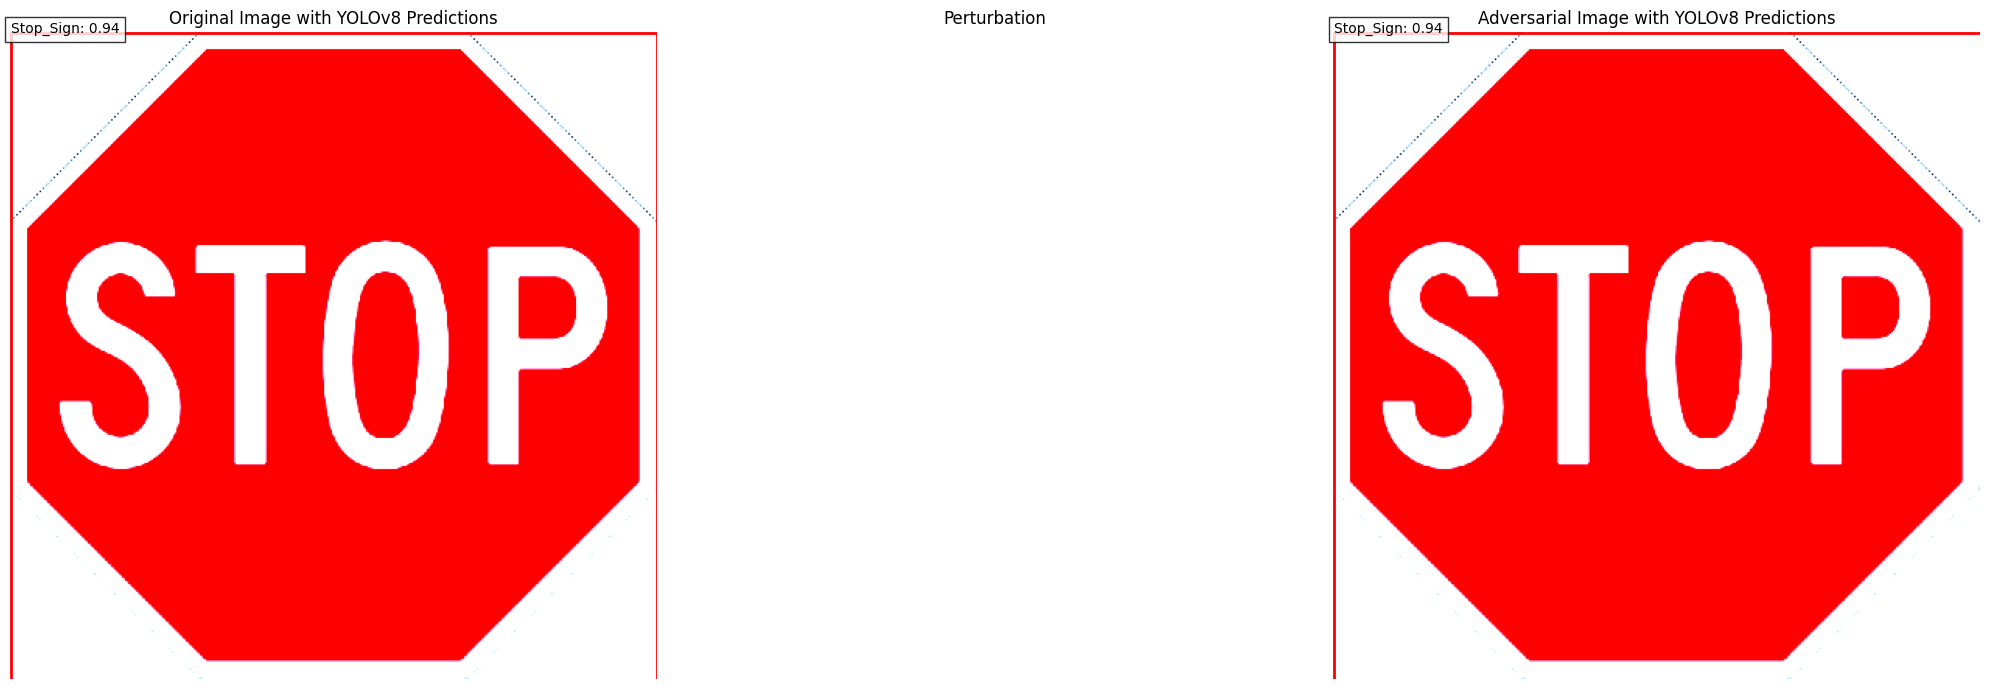

In [ ]:
pert_image = pert_image.squeeze(1)
pert_image_np = pert_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
YOLOm = YOLO('train\weights\best.pt')
# Ensure the image is in the [0, 1] range
pert_image_np = np.clip(pert_image_np, 0, 1)
# Get YOLO predictions for both original and perturbed images
boxes, scores, labels = get_yolo_output(YOLOm, image)
perturbed_boxes, perturbed_scores, perturbed_labels = get_yolo_output(YOLOm, pert_image)

# Plotting setup
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# 1. Original image with YOLO predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image, YOLOm)

# 2. Perturbation (visualized as the difference between the original and perturbed image)
perturbation = (pert_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())  # Normalize to [0, 1]
perturbation = np.clip(perturbation, 0, 1)

axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')  # Hide axes for clarity

# 3. Adversarial image with YOLO predictions
plot_boxes(axs[2], perturbed_boxes, perturbed_scores, perturbed_labels, "Adversarial Image with YOLOv8 Predictions", perturbed_image, YOLOm)

# Tight layout for better spacing
plt.tight_layout()
plt.show()
